# Exercise Sheet 7

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

## 2 Log-sum-exp and soft(arg)max

### (a)

On which subset of the vectors $\sigma_1 = (1, 2, 3)^T$, $\sigma_2 = (11, 12, 13)^T$, $\sigma_3 = (10, 20, 30)^T$ does the soft(arg)max yield identical results? Show in general whether the soft(arg)max is invariant under
(i) constant offset and (ii) rescaling of its input.

![2a.jpg](2a.jpg)

see also:

In [2]:
sigmas = np.array([[1, 2, 3], [11, 12, 13], [10, 20, 30]])

In [3]:
soft = np.array([np.exp(s)/np.sum(np.exp(s)) for s in sigmas]) 

In [4]:
for s in soft:
    print(np.round(s, 5))

[0.09003 0.24473 0.66524]
[0.09003 0.24473 0.66524]
[0.0000e+00 5.0000e-05 9.9995e-01]


### (b)

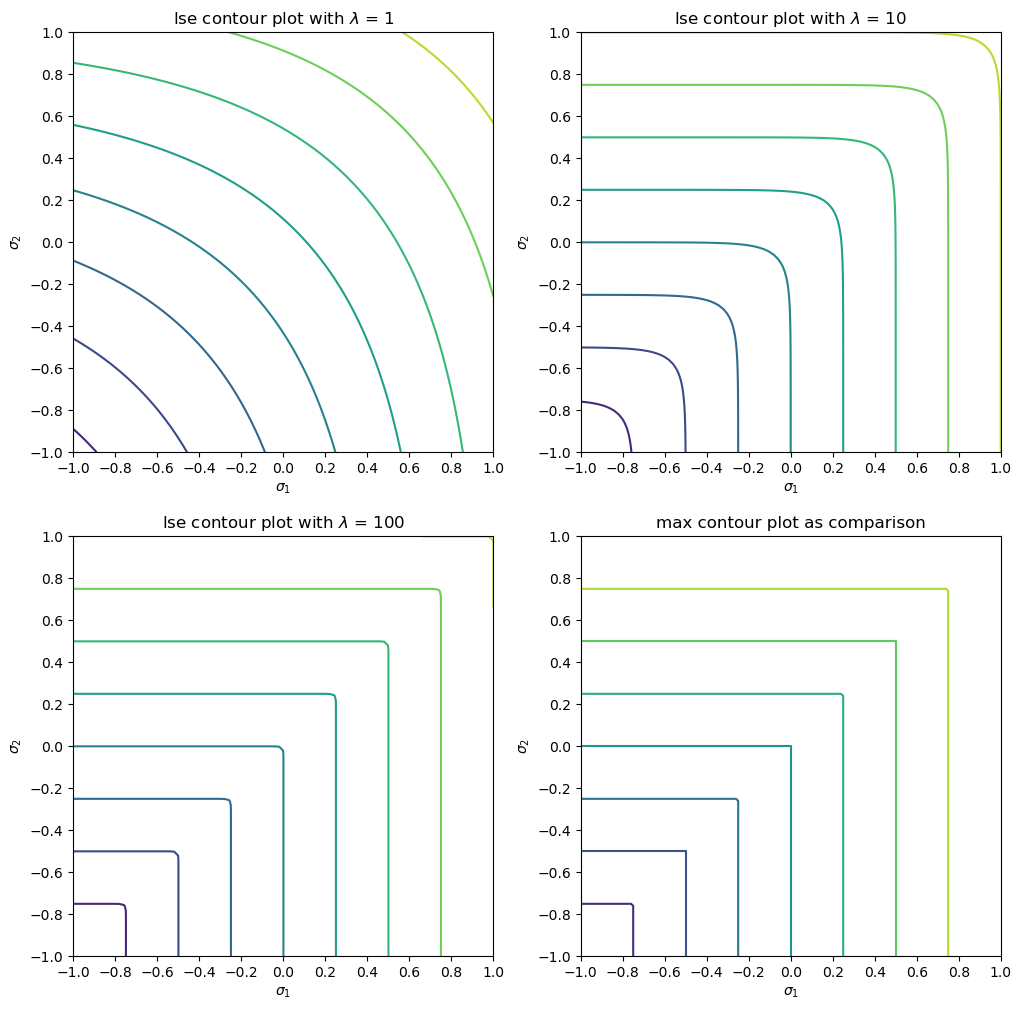

In [5]:
def logsumexp(x, lamb=1):
    # TODO: implement the logsumexp
    return (1/lamb) * np.log(np.sum(np.exp(x)**lamb))
    

# TODO: set up a grid of points in [-1, 1] x [-1, 1]
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)
X,Y = np.meshgrid(x, y)
xy = np.array([X,Y])

# TODO: I recommend you set up a function to set up an Axes object with the correct x, y labels, 
#       equal aspect and maybe x and y ticks.

def set_up_axes(ax):
    ax.set_xlabel("$\sigma_1$")
    ax.set_ylabel("$\sigma_2$")
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(-1, 1, 11))
    ax.set_yticks(np.linspace(-1, 1, 11))
  
    
# TODO: calculate and plot the functions as specified in the task
lambdas = [1, 10, 100]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# evaluating the functions and plotting them
for (k,l), ax in zip(enumerate(lambdas), axs.flatten()):
    Z = np.empty(X.shape)
    Z_max = np.empty(Z.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i,j] = logsumexp((X[i,j],Y[i,j]), lamb=l)
            Z_max[i,j] = np.max((X[i,j],Y[i,j]))
    
    # plotting the lse contour 
    ax.contour(X, Y, Z)
    set_up_axes(ax)
    ax.set_title("lse contour plot with $\lambda$ = " + str(l))
    
    
#plotting the max contour
axs[1,1].contour(X, Y, Z_max)
set_up_axes(axs[1,1])
axs[1,1].set_title("max contour plot as comparison")
plt.show()

For higher $\lambda$, the contours of lse get more "edged", they more closely resemple the shape of the max-contours. This is expected, as for $\lambda \rightarrow \inf$ the exponent in the lse gets very high and within the sum, the term with the largest $\sigma_j$ dominates expression, i.e. the maximal value dominates the log-sum-exp.

### (c)

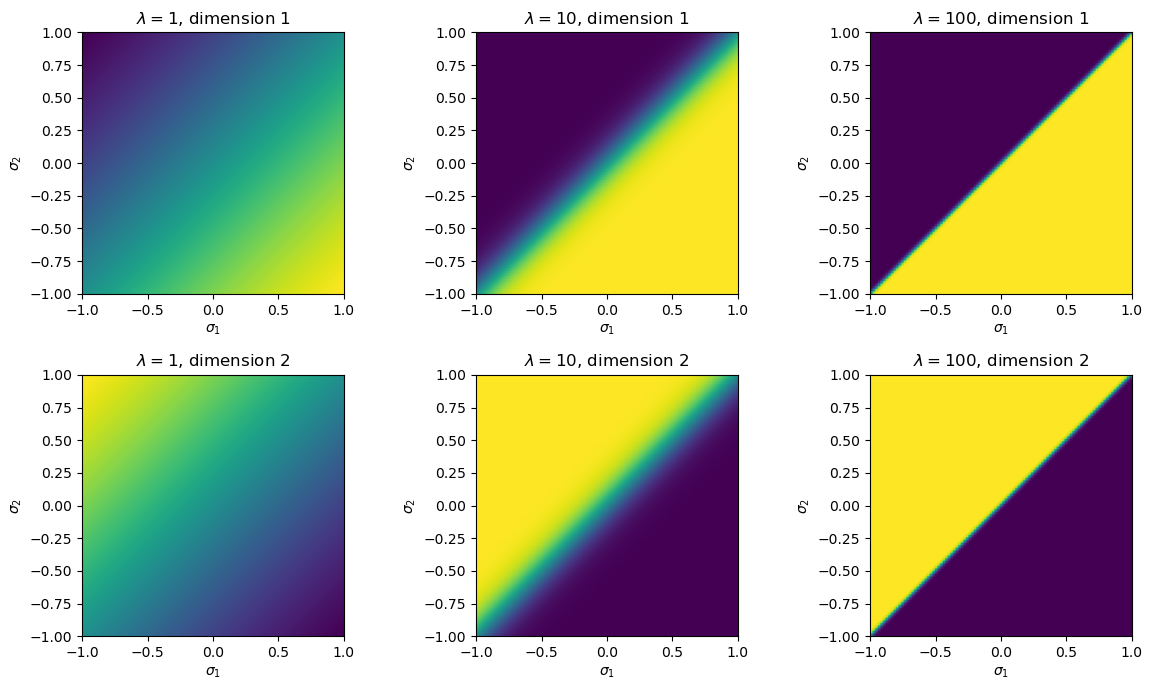

In [6]:
def softmax(xy, axis, lamb=1):
    # TODO: implement the softmax function. Axis should specify along which axis the sums should be computed.
    return np.exp(xy)**lamb / np.sum(np.exp(xy)**lamb, axis=axis)


# TODO: make the plots as specified on the sheet (nicest is in a grid which you can get using plt.subplots)

# plot the softmax
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for i,l in enumerate(lambdas):
    sm = softmax(xy, 0, lamb=l)
    ax = axs[0,i]
    ax.imshow(sm[0], origin='lower', extent=(-1,1,-1,1))
    ax.set_title(f'$\lambda={l}$, dimension 1')
    ax.set_xlabel('$\sigma_1$')
    ax.set_ylabel('$\sigma_2$')
    ax = axs[1,i]
    ax.imshow(sm[1], origin='lower', extent=(-1,1,-1,1))
    ax.set_title(f'$\lambda={l}$, dimension 2')
    ax.set_xlabel('$\sigma_1$')
    ax.set_ylabel('$\sigma_2$')
plt.tight_layout()
plt.show()

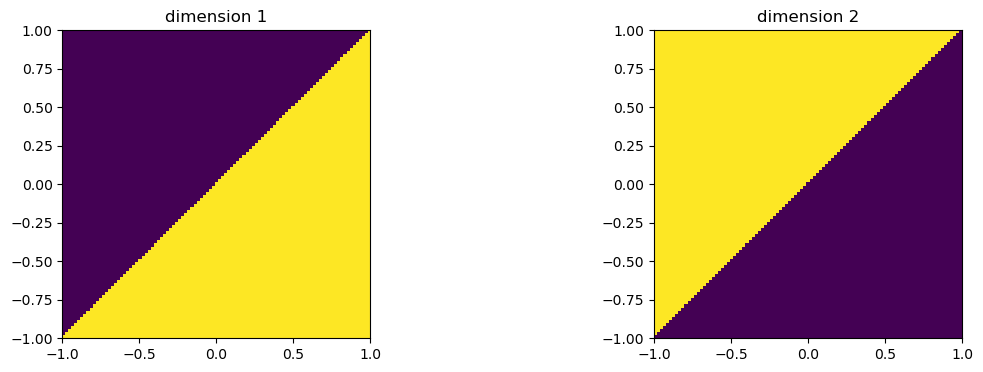

In [7]:
# TODO: compute the argmax of each gridpoint in one-hot form
onehot_argmax = F.one_hot(torch.tensor(np.argmax(xy, axis=0)), num_classes=2)
        
# plot the onehot argmax
plt.subplots(1,2, figsize=(14,4))
plt.subplot(1,2,1).imshow(onehot_argmax[:,:,0], origin='lower', extent=(-1,1,-1,1))
plt.title('dimension 1')
plt.subplot(1,2,2).imshow(onehot_argmax[:,:,1], origin='lower', extent=(-1,1,-1,1))
plt.title('dimension 2')
plt.show()

As expected, for large $\lambda$ the softmax approaches the argmax function.

### (d)

![2d.jpg](2d.jpg)

### (e) Bonus

Proof of concept proof :P

lim of lse, use l'Hôpital's rule, 1/lambda goes away and lse becomes softmax.
Softmax has lambda in exponent, i.e. "to the power of lambda". For very large lambda -> inf, the term explodes for sigma_k > sigma_j and vanishes for sigma_k < sigma_j (for all j !=k). Therefore, is becomes =1 for the maximum value and =0 for the rest.

## 3 Linear regions of MLPs

### (a)

In [8]:
class Abs(nn.Module):
    """Absolute value activation function. You can experiment with this instead of ReLU."""
    def forward(self, x):
        return x.abs()


# define NN architecture.
class MLPShallow(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        self.fc0 = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc0(x)
        x = torch.relu(x)
        output = self.fc1(x)
        return output

# Define model hyperparameters
input_size = 2
hidden_size = 20
output_size = 1

# Create model
model = MLPShallow(input_size, hidden_size, output_size)

In [9]:
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param, '\n')

fc0.weight torch.Size([20, 2])
Parameter containing:
tensor([[-0.1948,  0.4149],
        [-0.2091, -0.2361],
        [ 0.4013, -0.6957],
        [-0.0179, -0.0325],
        [-0.4188,  0.0412],
        [ 0.7000,  0.4127],
        [-0.4603,  0.1211],
        [ 0.3193,  0.4511],
        [-0.4523, -0.2045],
        [ 0.3708, -0.5033],
        [-0.6202, -0.1832],
        [-0.5329, -0.0676],
        [ 0.5918, -0.6846],
        [ 0.4714, -0.6943],
        [ 0.4020, -0.4481],
        [-0.5139,  0.0584],
        [ 0.4005, -0.1392],
        [ 0.6438, -0.2700],
        [ 0.5120,  0.3735],
        [-0.4218, -0.5605]], requires_grad=True) 

fc0.bias torch.Size([20])
Parameter containing:
tensor([-0.4358,  0.0572, -0.4954, -0.1172, -0.2258, -0.0868, -0.5897,  0.1928,
         0.5951,  0.2349, -0.4356,  0.5685,  0.0561, -0.1633, -0.4368, -0.1131,
        -0.0117, -0.0458,  0.0901, -0.5380], requires_grad=True) 

fc1.weight torch.Size([1, 20])
Parameter containing:
tensor([[ 0.0811, -0.1118,  0.0566, 

The model has a total of 81 parameters: Each of the 20 hidden layer neurons have two weights (for the two input dimensions) and one bias value. The output neuron has 20 weights and one bias value.

$$ 2 \cdot 20 + 20 + 1 \cdot 20 + 1 = 81 $$

### (b)

/home/jay/miniconda3/envs/mlph/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642881969/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


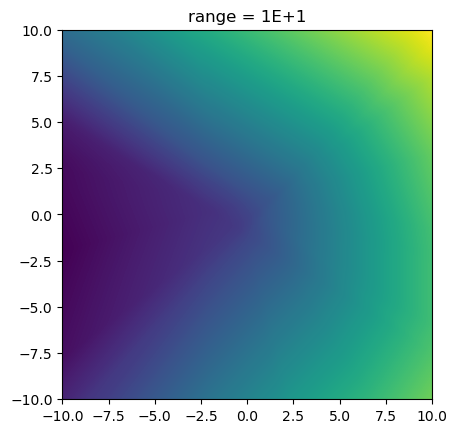

In [10]:
def visualize_model(model, res=500, bound=5, show_image=True, show_directly=True, return_output=False):
    # TODO: implement a function that takes the model (the MLP), and builds a 
    #       grid of points in [-bound, bound] x [-bound, bound], passes them 
    #       through the model and returns the result in the shape of an image
    x = torch.linspace(-bound, bound, res)
    y = torch.linspace(-bound, bound, res)
    X, Y = torch.meshgrid(x, y)
    points = torch.stack([X, Y], dim=-1).reshape(-1, 2)

    # Forward pass the input through the model
    output = model(points)

    # Reshape the output to match image shape
    output = output.reshape(res, res).detach().numpy()

    # Plot as image
    if show_image:
        plt.imshow(output, origin='lower', extent=[-bound, bound, -bound, bound], interpolation=None)
        if show_directly:
            plt.show()
    
    if return_output:
        return output

# TODO: instantiate the model and make the visualizations as requested in the task
# NOTE: If you get a constant output, you got an unlucky initialization. Simply reinitialize the model.

# Define the model
input_size = 2
hidden_size = 20
output_size = 1

# Create
model = MLPShallow(input_size, hidden_size, output_size)

# Visualize
plt.title('range = 1E+1')
visualize_model(model, res=1000, bound=10)

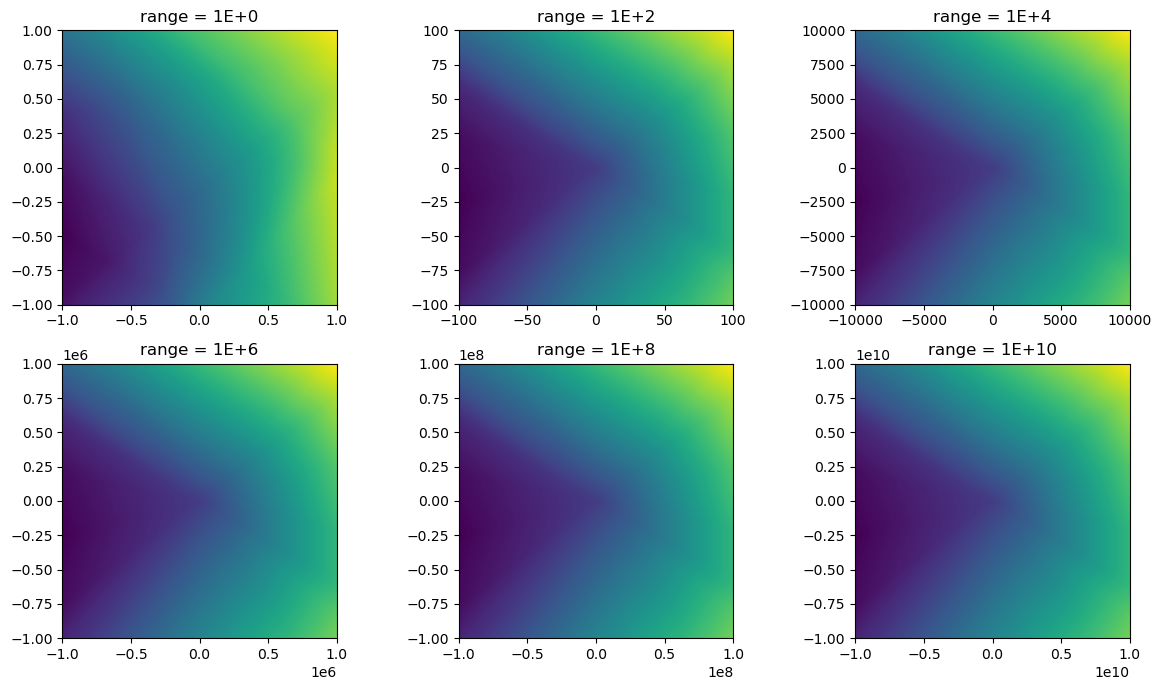

In [11]:
plt.subplots(2,3, figsize=(12,7))
for i,r in enumerate(range(0, 11, 2)):
    plt.subplot(2,3,i+1)
    plt.title('range = 1E+'+str(r))
    visualize_model(model, res=1000, bound=10**r, show_directly=False)
plt.tight_layout()
plt.show()

### (c)

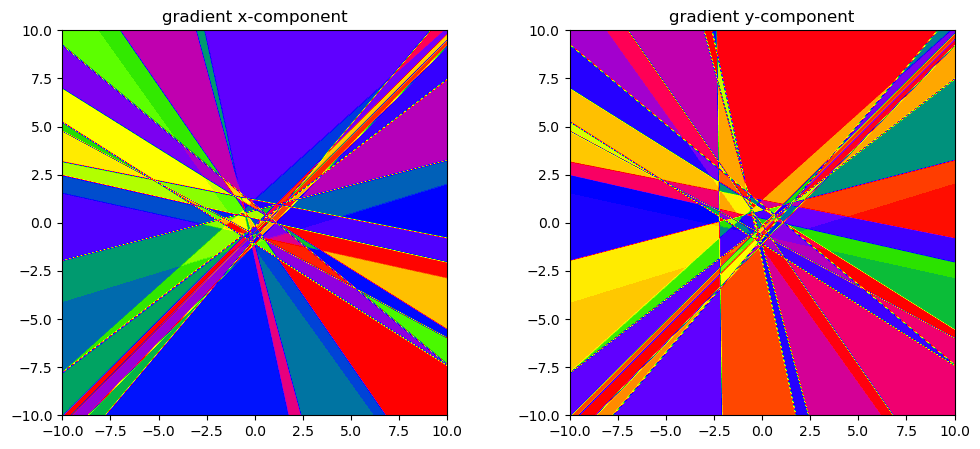

In [12]:
# TODO: compute the spatial gradient of the network outputs (as an image) from (b)
#       using np.gradient, and visualize using matplotlib's prism colormap

bound = 10
gx, gy = np.gradient(visualize_model(model, res=1000, bound=bound, show_image=False, return_output=True))

plt.subplots(1,2, figsize=(12,5))
plt.subplot(1,2,1).imshow(gx, cmap='prism', origin='lower', extent=[-bound, bound, -bound, bound], interpolation=None)
plt.title('gradient x-component')
plt.subplot(1,2,2).imshow(gy, cmap='prism', origin='lower', extent=[-bound, bound, -bound, bound], interpolation=None)
plt.title('gradient y-component')
plt.show()

We observe beautiful caleidoscopic images.

More precisely, we observe steep gradients / steps along straight lines. Counting along the perimeter of the plot reveals (roughly, counting is hard here) 20 lines. These correspond to the 20 neurons, i.e. linear fits in 2D space that the model performs.

The lines appear evenly spaced in direction, and randomly offset from the center, with more lines close to the center than further away. This suggests that the random initialization is working. The bias initialization looks possibly gaussian.

### (d)

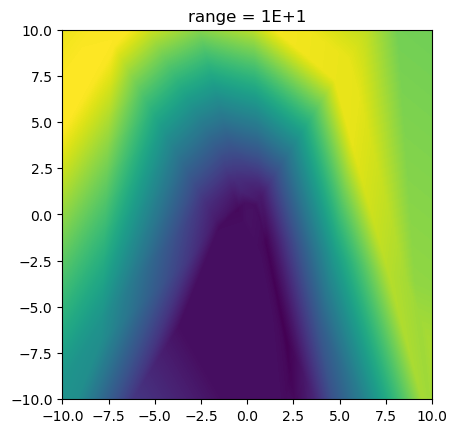

In [13]:
# define NN architecture.
class MLPDeep(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        self.fc0 = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        # TODO: pass the input x through the layers and return the output
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = self.fc4(x)
        return output

# TODO: repeat the visualizations from above

# Define the model
input_size = 2
hidden_size = 5
output_size = 1

# Create
model = MLPDeep(input_size, hidden_size, output_size)

# Visualize
plt.title('range = 1E+1')
visualize_model(model, res=1000, bound=10)

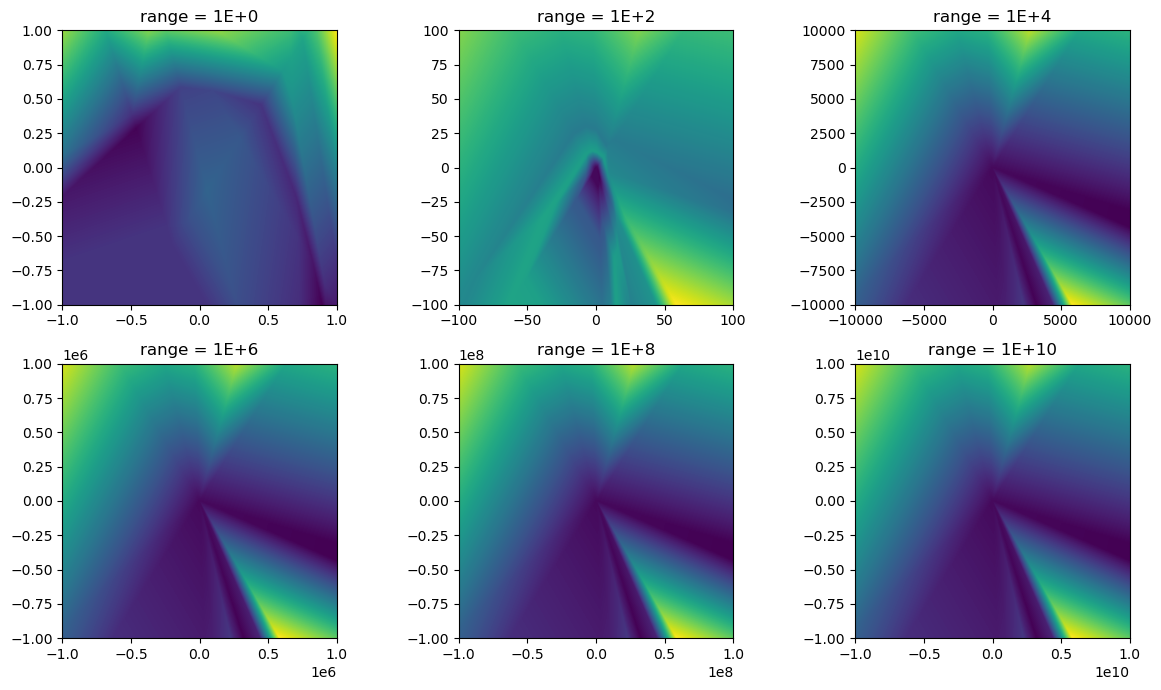

In [14]:
plt.subplots(2,3, figsize=(12,7))
for i,r in enumerate(range(0, 11, 2)):
    plt.subplot(2,3,i+1)
    plt.title('range = 1E+'+str(r))
    visualize_model(model, res=1000, bound=10**r, show_directly=False)
plt.tight_layout()
plt.show()

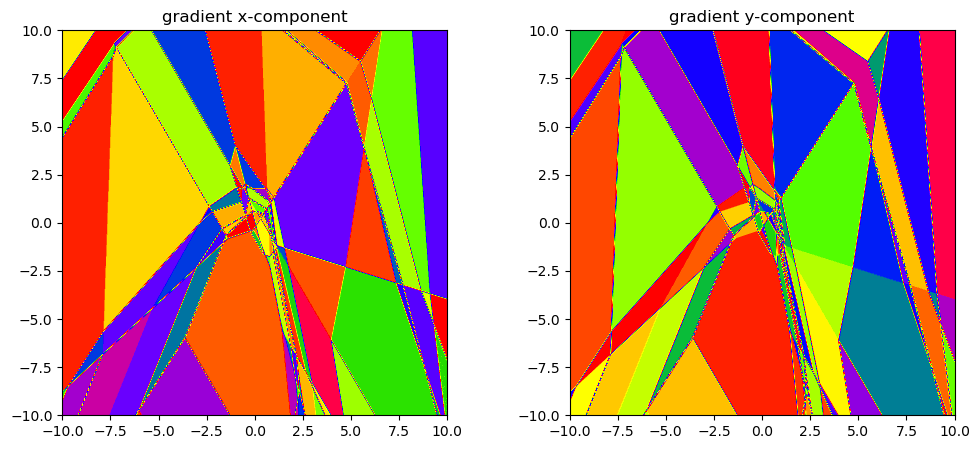

In [15]:
bound = 10
gx, gy = np.gradient(visualize_model(model, res=1000, bound=bound, show_image=False, return_output=True))

plt.subplots(1,2, figsize=(12,5))
plt.subplot(1,2,1).imshow(gx, cmap='prism', origin='lower', extent=[-bound, bound, -bound, bound], interpolation=None)
plt.title('gradient x-component')
plt.subplot(1,2,2).imshow(gy, cmap='prism', origin='lower', extent=[-bound, bound, -bound, bound], interpolation=None)
plt.title('gradient y-component')
plt.show()

For the deeper model, the neurons create larger, more connected regions. In particular, they are no longer linear, which can be seen as they are no longer visible as straight lines.

## 4 Bonus: Number of linear regions

What is the maximum number of linear regions of an MLP with a two dimensional input and one hidden
layer with $n$ neurons and ReLU activations? Hint: Consider the construction in the lecture, representing
each hidden neuron as a line in the input space.

The number of linear regions corresponds to the number of regions formed / enclosed by the $n$ intersecting lines of the $n$ neurons in 2D input space.

The number is maximal if no lines are parallel, i.e. no two neurons have identical weights. Therefore, we assume non-parallel lines.

One line divides the plane into 2 regions: $R_1 = 2$

Each $n$-th new line intersects each of the existing $n-1$ lines in some point. Considering these intersections ordered along the line, each creates one additional region to its right, plus one region in the beginning to the left. Thus, each new line also adds $n$ new regions.

$$ R_n = R_{n-1} + n $$

The solution of this recursion is just the sum of all numbers from $2$ to $n$. This is equal to one plus $\sum_{i=1}^{n}{i}$, which was famously computed by Carl Friedrich Gauß to be $= \frac{n(n+1)}{2}$.

Therefore, the number of regions between $n$ lines, and thus the number of linear regions for $n$ neurons, is:


$$ R_n = \frac{n(n+1)}{2} + 1 $$